# Using Machine Learning Models for Loan Approval prediction – A comparative study
This project utilizes the "Loan Status Prediction" dataset, sourced from a Kaggle, to develop machine learning models capable of predicting loan approval outcomes.

In [ ]:
# Importing necessary libraries
import pandas as pdD
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

from sklearn import preprocessing
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split

# For Class Imbalance Handling
from imblearn.over_sampling import SMOTE

# For Google Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Loading Dataframe
og_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Final_project/Loan_default_prediction.csv")
og_df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


Here's a description of all the columns in our dataset

| Variable           | Description                                   |
|--------------------|-----------------------------------------------|
| Loan_ID            | Unique Loan ID                               |
| Gender             | Male/ Female                                 |
| Married            | Applicant married (Y/N)                      |
| Dependents         | Number of dependents                         |
| Education          | Applicant Education (Graduate/ Under Graduate) |
| Self_Employed      | Self-employed (Y/N)                          |
| ApplicantIncome    | Applicant income                             |
| CoapplicantIncome  | Coapplicant income                           |
| LoanAmount         | Loan amount in thousands                     |
| Loan_Amount_Term   | Term of loan in months                       |
| Credit_History     | Credit history meets guidelines              |
| Property_Area      | Urban/ Semi Urban/ Rural                     |
| Loan_Status        | (Target) Loan approved (Y/N)                 |


In [ ]:
og_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


- We have 8 categorical variables - one of which is Loan ID. It would be later dropped
- We have 5 numerical variables



---

# Data Processing 

In [ ]:
#Creating a copy
df = og_df.copy()

df.drop(["Loan_ID"], axis=1, inplace=True)

In [ ]:
df.isnull().sum() #Checking missing values

,0
Gender,13
Married,3
Dependents,15
Education,0
Self_Employed,32
ApplicantIncome,0
CoapplicantIncome,0
LoanAmount,22
Loan_Amount_Term,14
Credit_History,50


## Imputation for Missing values

In [ ]:
print(og_df.LoanAmount.mean(), " ",  og_df.LoanAmount.median())
print(og_df.Loan_Amount_Term.mean(), " ",  og_df.Loan_Amount_Term.median())

146.41216216216216   128.0
342.0   360.0


In [ ]:
# Impute categorical variables with mode
for col in ['Gender', 'Married', 'Dependents', 'Self_Employed', 'Credit_History']:
    df[col] = df[col].fillna(df[col].mode()[0])

# Impute numerical variables with median
for col in ['LoanAmount', 'Loan_Amount_Term']:
    df[col] = df[col].fillna(df[col].median())

Imputed the categorical variables - Gender, Married, Dependents, Self_employed, Credit_history - with Mode
Imputed the numeric variables - LoanAmount, Loan_Amount_Term - with median

In [ ]:
df.isnull().sum()

,0
Gender,0
Married,0
Dependents,0
Education,0
Self_Employed,0
ApplicantIncome,0
CoapplicantIncome,0
LoanAmount,0
Loan_Amount_Term,0
Credit_History,0


In [ ]:
# Convert int columns to float
for col in [5, 6, 7, 8]:
    try:
        df.iloc[:, col] = df.iloc[:, col].astype(float)
    except:
        print("Can't convert column", col)

## Initial EDA


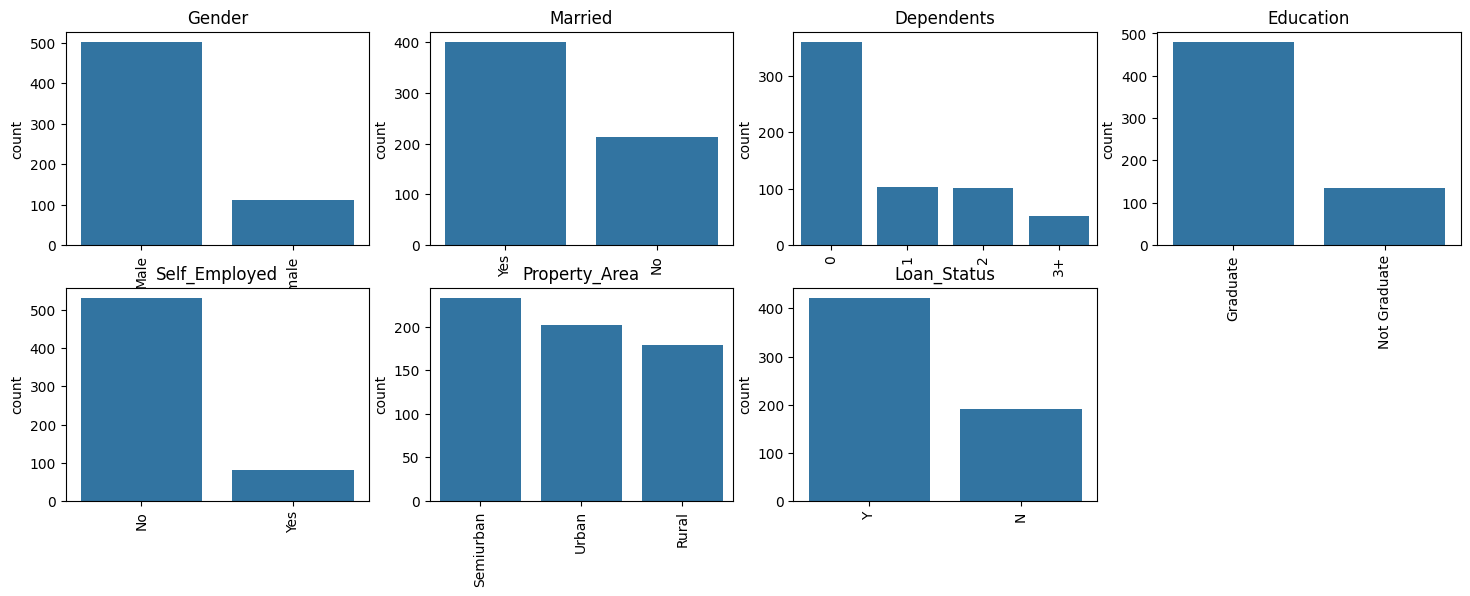

In [ ]:
obj = (df.dtypes == 'object')
object_cols = list(obj[obj].index)
plt.figure(figsize=(18,36))
index = 1

for col in object_cols:
  y = df[col].value_counts()
  plt.subplot(11,4,index)
  plt.xticks(rotation=90)
  plt.title(col)
  sns.barplot(x=list(y.index), y=y)
  index +=1



*   We can see that our target variable has a class imbalance - we can address that with Oversampling
*   We can see that Credit History column did not show up, implying that it is already encoded.



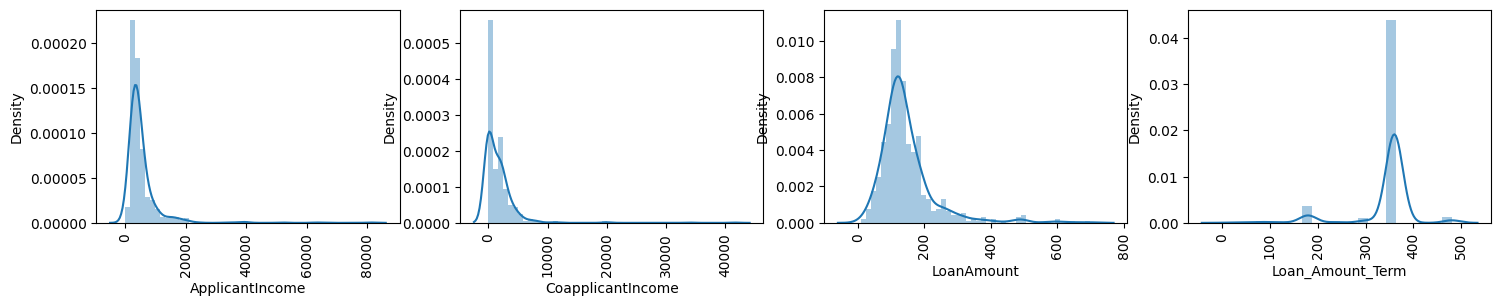

In [ ]:

num = [5,6,7,8]
# Instead of using list as index, get the columns names directly using iloc and column indices
num_cols = df.iloc[:, num].columns.tolist()
plt.figure(figsize=(18, 36))
index = 1

for col in num_cols:
    y = df[col].value_counts()
    plt.subplot(11, 4, index)
    plt.xticks(rotation=90)
    sns.distplot(df[col])  # Use distplot for numeric data
    index += 1


*   We can see that Loan Amount Term column is not properly distributed, with most values centered around 360
*   The Loan Amount column on the other hand has values in the different scale from other two Income columns - Applicant Income, and Coaaplicant income




In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             614 non-null    object 
 1   Married            614 non-null    object 
 2   Dependents         614 non-null    object 
 3   Education          614 non-null    object 
 4   Self_Employed      614 non-null    object 
 5   ApplicantIncome    614 non-null    float64
 6   CoapplicantIncome  614 non-null    float64
 7   LoanAmount         614 non-null    float64
 8   Loan_Amount_Term   614 non-null    float64
 9   Credit_History     614 non-null    float64
 10  Property_Area      614 non-null    object 
 11  Loan_Status        614 non-null    object 
dtypes: float64(5), object(7)
memory usage: 57.7+ KB


## Label Encoding

In [ ]:
#Label encoding
label_encoder = preprocessing.LabelEncoder()
obj = (df.dtypes == 'object')
for col in list(obj[obj].index):
  if col != "Dependents":
    df[col] = label_encoder.fit_transform(df[col])
    print(f"Mappings for column '{col}':")  # Print column name
    # Get mappings and print them
    for i, category in enumerate(label_encoder.classes_):
        print(f"  '{category}' -> {i}")

Mappings for column 'Gender':
  'Female' -> 0
  'Male' -> 1
Mappings for column 'Married':
  'No' -> 0
  'Yes' -> 1
Mappings for column 'Education':
  'Graduate' -> 0
  'Not Graduate' -> 1
Mappings for column 'Self_Employed':
  'No' -> 0
  'Yes' -> 1
Mappings for column 'Property_Area':
  'Rural' -> 0
  'Semiurban' -> 1
  'Urban' -> 2
Mappings for column 'Loan_Status':
  'N' -> 0
  'Y' -> 1


## Creating Dummies for Dependents Variable

In [ ]:
if 'Dependents_1' in df.columns:
  df.drop("Dependents", inplace = True, axis = 1)
  df.head()
else:
  df['Dependents'] = df['Dependents'].replace('3+', '3')
  dependents_dummies = pd.get_dummies(df['Dependents'], prefix='Dependents')
  df = pd.concat([df, dependents_dummies], axis=1)


In [ ]:
df.drop("Dependents", inplace = True, axis = 1)
df.head()
df.describe()

,Gender,Married,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
count,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000
mean,0.817590,0.653094,0.218241,0.133550,5403.459283,1621.245798,145.752443,342.410423,0.855049,1.037459,0.687296
std,0.386497,0.476373,0.413389,0.340446,6109.041673,2926.248369,84.107233,64.428629,0.352339,0.787482,0.463973
min,0.000000,0.000000,0.000000,0.000000,150.000000,0.000000,9.000000,12.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,2877.500000,0.000000,100.250000,360.000000,1.000000,0.000000,0.000000
50%,1.000000,1.000000,0.000000,0.000000,3812.500000,1188.500000,128.000000,360.000000,1.000000,1.000000,1.000000
75%,1.000000,1.000000,0.000000,0.000000,5795.000000,2297.250000,164.750000,360.000000,1.000000,2.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,81000.000000,41667.000000,700.000000,480.000000,1.000000,2.000000,1.000000


In [ ]:
df.Credit_History = df.Credit_History.astype('int64')
df.Dependents_0 = df.Dependents_0.astype('int64')
df.Dependents_1 = df.Dependents_1.astype('int64')
df.Dependents_2 = df.Dependents_2.astype('int64')
df.Dependents_3 = df.Dependents_3.astype('int64')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             614 non-null    int64  
 1   Married            614 non-null    int64  
 2   Education          614 non-null    int64  
 3   Self_Employed      614 non-null    int64  
 4   ApplicantIncome    614 non-null    float64
 5   CoapplicantIncome  614 non-null    float64
 6   LoanAmount         614 non-null    float64
 7   Loan_Amount_Term   614 non-null    float64
 8   Credit_History     614 non-null    int64  
 9   Property_Area      614 non-null    int64  
 10  Loan_Status        614 non-null    int64  
 11  Dependents_0       614 non-null    int64  
 12  Dependents_1       614 non-null    int64  
 13  Dependents_2       614 non-null    int64  
 14  Dependents_3       614 non-null    int64  
dtypes: float64(4), int64(11)
memory usage: 72.1 KB


## Label Encoding

In [ ]:
# if the loan term is 360 and more then it is a long term loan, otherwise it is a short term loan
df['LongTermLoan'] = df['Loan_Amount_Term'].apply(lambda x: 1 if x >= 360 else 0)
df.drop("Loan_Amount_Term", inplace = True, axis = 1)
df.head()

,Gender,Married,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Credit_History,Property_Area,Loan_Status,Dependents_0,Dependents_1,Dependents_2,Dependents_3,LongTermLoan
0,1,0,0,0,5849.0,0.0,128.0,1,2,1,1,0,0,0,1
1,1,1,0,0,4583.0,1508.0,128.0,1,0,0,0,1,0,0,1
2,1,1,0,1,3000.0,0.0,66.0,1,2,1,1,0,0,0,1
3,1,1,1,0,2583.0,2358.0,120.0,1,2,1,1,0,0,0,1
4,1,0,0,0,6000.0,0.0,141.0,1,2,1,1,0,0,0,1


## Standardizing Continuous Variables due to Scale Difference

([0, 1, 2],
 [Text(0, 0, 'ApplicantIncome'),
  Text(1, 0, 'CoapplicantIncome'),
  Text(2, 0, 'LoanAmount')])

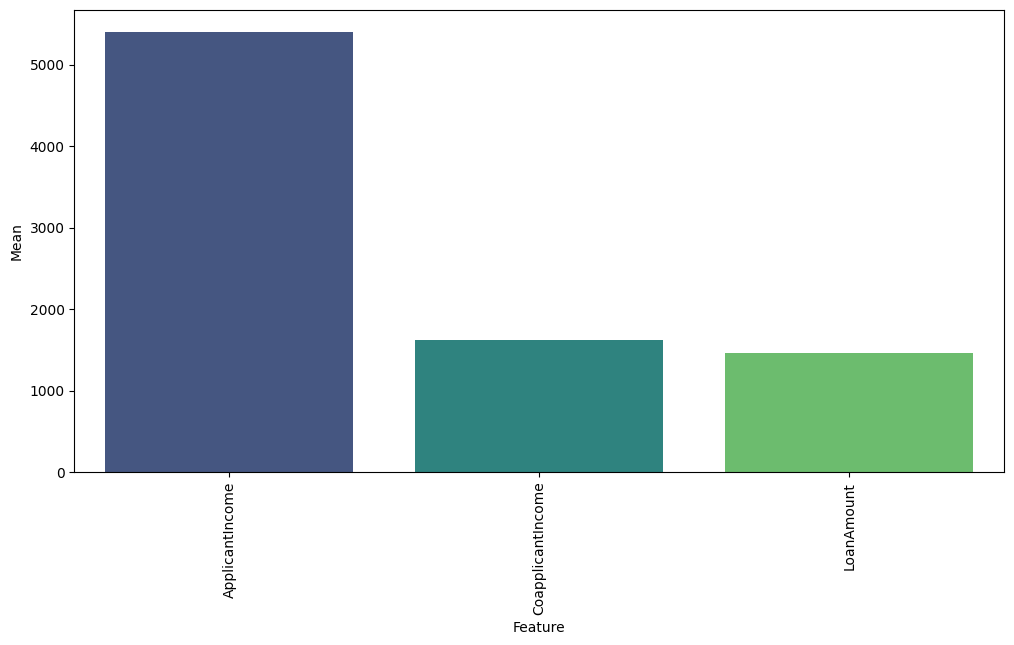

In [ ]:
obj = (df.dtypes == 'float64')
object_cols = list(obj[obj].index)
means = []
for col in object_cols:
  mean = df[col].mean()
  means.append(mean)

means[2] = means[2] * 10

plt.figure(figsize=(12, 6))  # Adjust figure size if needed

# Create a DataFrame for barplot
data = pd.DataFrame({'Feature': object_cols, 'Mean': means})

# Use the DataFrame and specify x and y columns
sns.barplot(x='Feature', y='Mean', data=data, palette='viridis')
plt.xticks(rotation=90)


In [ ]:
print("Applicant income range: ", df['ApplicantIncome'].max())
print("Coapplicant income range: ", df['CoapplicantIncome'].max())
print("Loan amount range: ", df['LoanAmount'].max())

Applicant income range:  81000.0
Coapplicant income range:  41667.0
Loan amount range:  700.0


In [ ]:
#Since the loan_amount, coapplicant income, and applicant income were in very different scale
# We use the standard scaler to scale the continuous variables
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

#Multiplying Loan amound by 1000 since the value is in thousands
df['LoanAmount'] = df['LoanAmount'] * 1000
float_cols = df.dtypes[df.dtypes == 'float64'].index.tolist()
df[float_cols] = scaler.fit_transform(df[float_cols])


print("Final Preprocessed Data\n")
print("\n", df.info(), "\n")
df.head()

Final Preprocessed Data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             614 non-null    int64  
 1   Married            614 non-null    int64  
 2   Education          614 non-null    int64  
 3   Self_Employed      614 non-null    int64  
 4   ApplicantIncome    614 non-null    float64
 5   CoapplicantIncome  614 non-null    float64
 6   LoanAmount         614 non-null    float64
 7   Credit_History     614 non-null    int64  
 8   Property_Area      614 non-null    int64  
 9   Loan_Status        614 non-null    int64  
 10  Dependents_0       614 non-null    int64  
 11  Dependents_1       614 non-null    int64  
 12  Dependents_2       614 non-null    int64  
 13  Dependents_3       614 non-null    int64  
 14  LongTermLoan       614 non-null    int64  
dtypes: float64(3), int64(12)
memory usage: 72.1 KB

 

,Gender,Married,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Credit_History,Property_Area,Loan_Status,Dependents_0,Dependents_1,Dependents_2,Dependents_3,LongTermLoan
0,1,0,0,0,0.072991,-0.554487,-0.211241,1,2,1,1,0,0,0,1
1,1,1,0,0,-0.134412,-0.038732,-0.211241,1,0,0,0,1,0,0,1
2,1,1,0,1,-0.393747,-0.554487,-0.948996,1,2,1,1,0,0,0,1
3,1,1,1,0,-0.462062,0.251980,-0.306435,1,2,1,1,0,0,0,1
4,1,0,0,0,0.097728,-0.554487,-0.056551,1,2,1,1,0,0,0,1


## EDA With Pre-Processed Features

Checking the percentage distribution of loan application success of the applicants according to the features. 

In [ ]:
def category_percentages(df):

    ## Calculates the percentage distribution of each category for categorical (int64 Dtype) variables.

    int64_cols = df.select_dtypes(include='int64').columns
    data = []

    for col in int64_cols:
        if col != 'Loan_Status':
            # Calculate value counts and percentages
            counts = df[col].value_counts()
            percentages = counts / len(df) * 100

            # Append data to the list for the table
            for value, percentage in percentages.items():
                data.append([col, value, percentage])

    # Creating a DataFrame
    table = pd.DataFrame(data, columns=['Variable', 'Category', 'Percentage'])
    return table


category_percentage_table = category_percentages(df)
print(category_percentage_table)

          Variable  Category  Percentage
0           Gender         1   81.758958
1           Gender         0   18.241042
2          Married         1   65.309446
3          Married         0   34.690554
4        Education         0   78.175896
5        Education         1   21.824104
6    Self_Employed         0   86.644951
7    Self_Employed         1   13.355049
8   Credit_History         1   85.504886
9   Credit_History         0   14.495114
10   Property_Area         1   37.947883
11   Property_Area         2   32.899023
12   Property_Area         0   29.153094
13    Dependents_0         1   58.631922
14    Dependents_0         0   41.368078
15    Dependents_1         0   83.387622
16    Dependents_1         1   16.612378
17    Dependents_2         0   83.550489
18    Dependents_2         1   16.449511
19    Dependents_3         0   91.693811
20    Dependents_3         1    8.306189
21    LongTermLoan         1   88.110749
22    LongTermLoan         0   11.889251


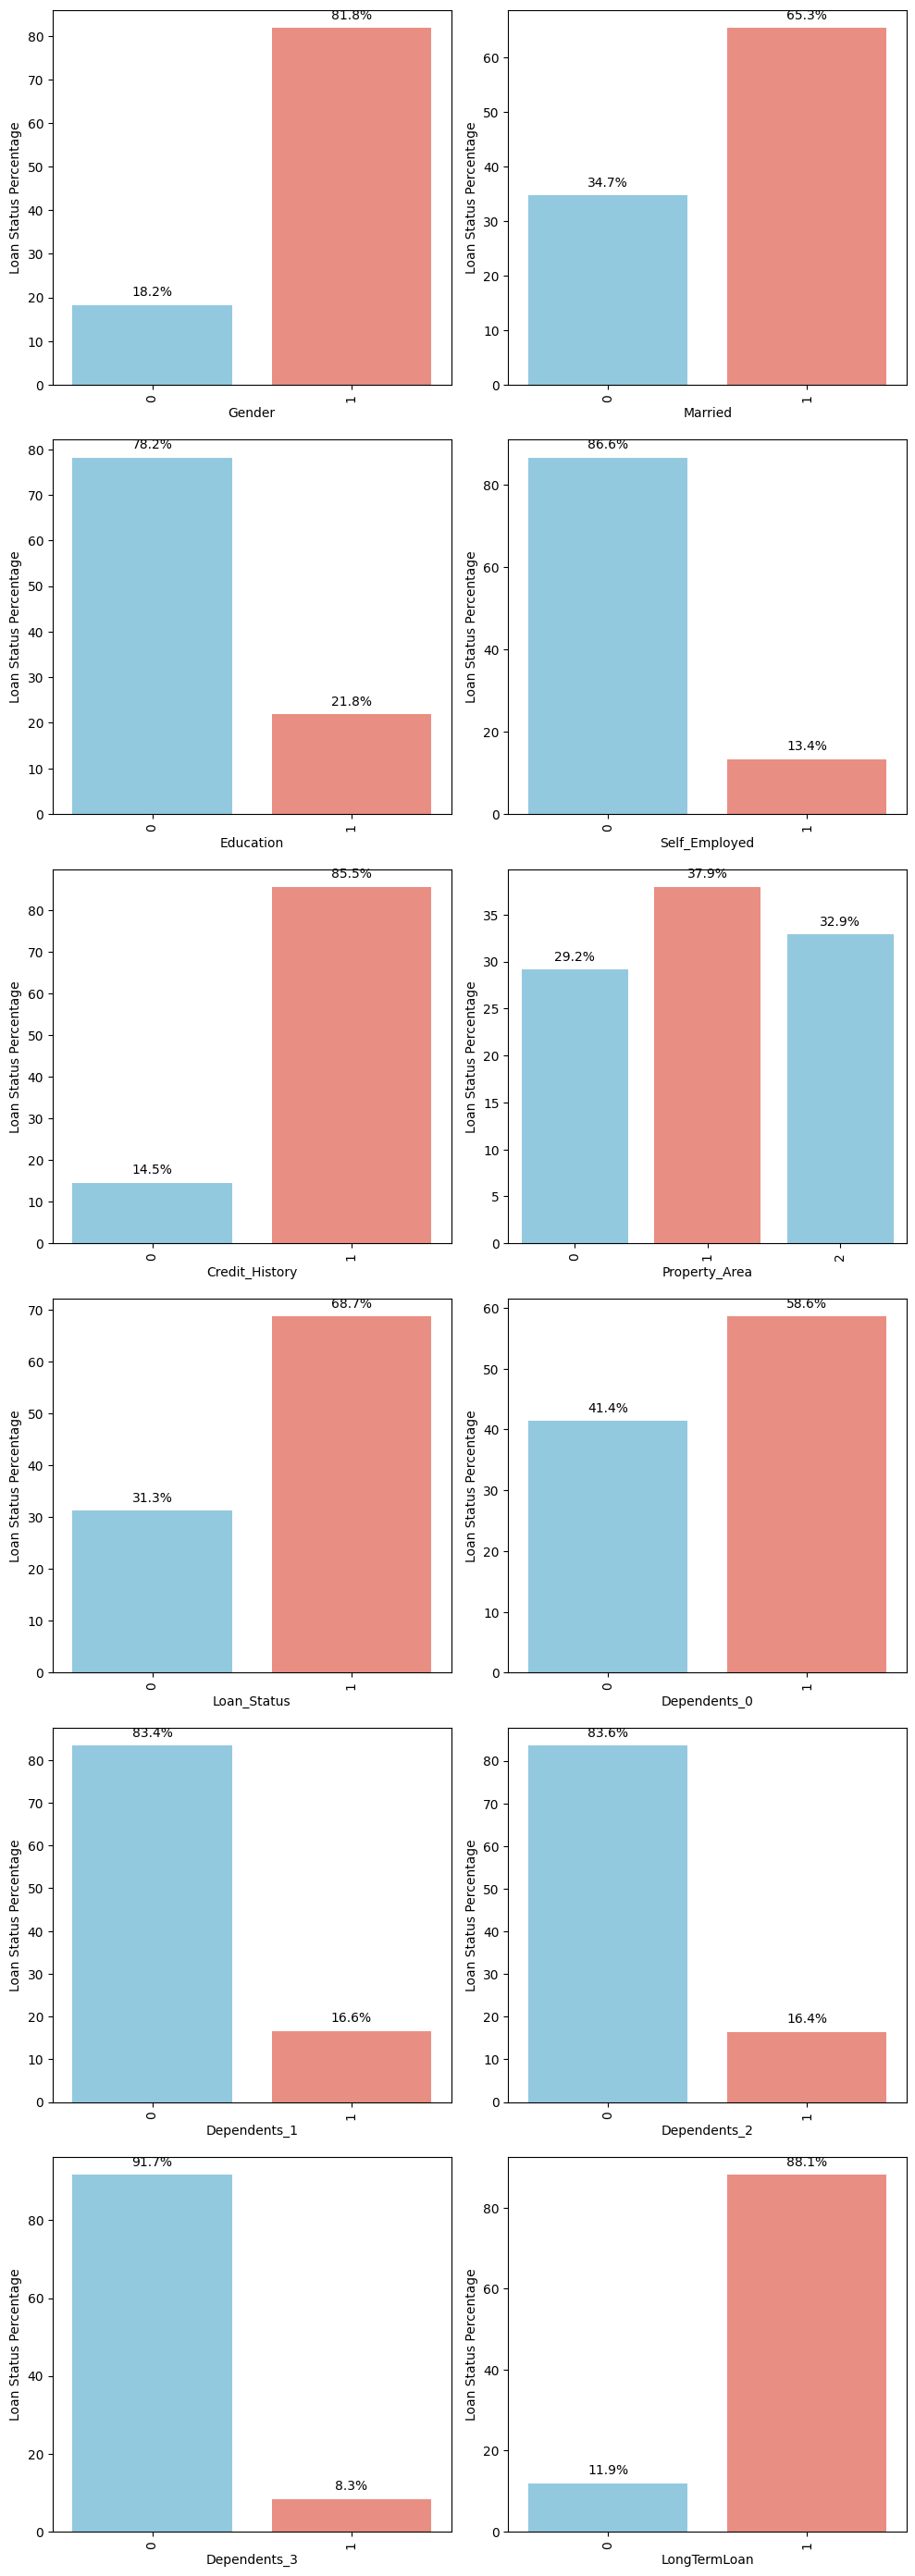

In [ ]:
#Creating plots for the above distribution

obj = (df.dtypes == 'int64')
object_cols = list(obj[obj].index)
plt.figure(figsize=(10,28))
index = 1

num_cols = len(object_cols)
num_rows = (num_cols + 1) // 2

for col in object_cols:
    # Calculate value counts and percentages
    counts = df[col].value_counts()
    percentages = counts / len(df) * 100

    plt.subplot(num_rows, 2, index)
    plt.xticks(rotation=90)

    # Create bar plot with custom palette
    ax = sns.barplot(x=list(counts.index), y=percentages, palette=['skyblue', 'salmon'])

    # Add annotations
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.1f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext=(0, 10), textcoords='offset points')

    plt.ylabel("Loan Status Percentage")

    # Set x-axis label to the column name
    plt.xlabel(col)

    index += 1

plt.tight_layout()
plt.show()

## Correlation Analysis

<Axes: >

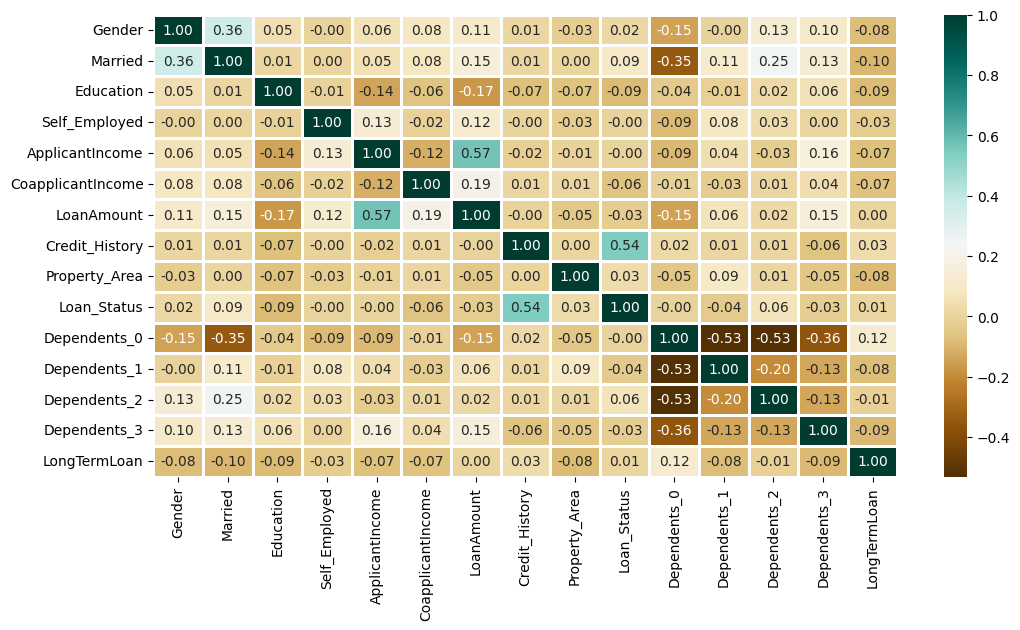

In [ ]:
preprocessed_df = df.copy()
plt.figure(figsize=(12,6))

sns.heatmap(preprocessed_df.corr(),cmap='BrBG',fmt='.2f', linewidths=2,annot=True)

In [ ]:
# Calculate the correlation of each feature with 'Loan_Status'
correlation_with_loan_status = round(preprocessed_df.corr()['Loan_Status'].drop('Loan_Status').sort_values(),3)

# Print the correlations
correlation_with_loan_status

,Loan_Status
Education,-0.086
CoapplicantIncome,-0.059
Dependents_1,-0.039
LoanAmount,-0.033
Dependents_3,-0.026
ApplicantIncome,-0.005
Self_Employed,-0.004
Dependents_0,-0.003
LongTermLoan,0.013
Gender,0.018


## Resampling The Target Variable due to Class Imbalance

<Axes: xlabel='Loan_Status', ylabel='count'>

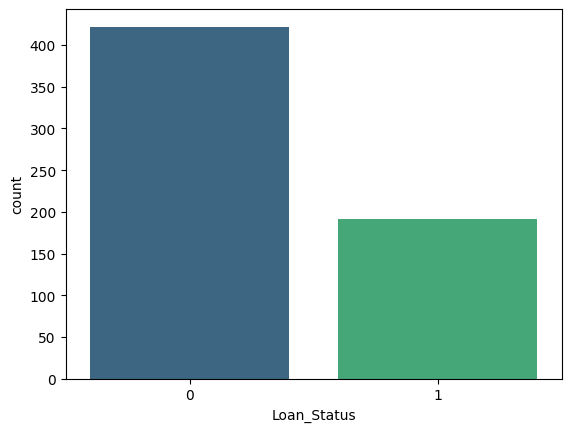

In [ ]:
sns.barplot(x='Loan_Status', y=df['Loan_Status'].value_counts(), data=preprocessed_df, palette='viridis')

# We can see that there is a major class imbalance.
# To address the imbalance we will use oversampling

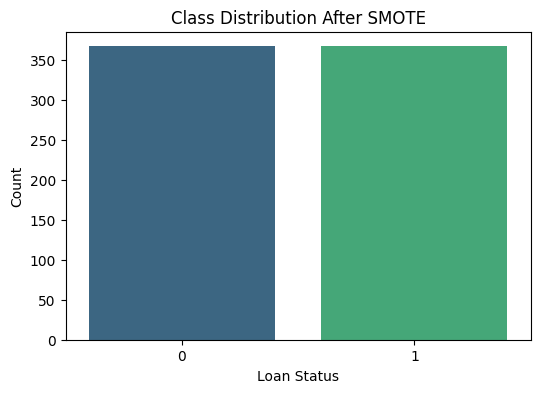

In [ ]:
# Split data into training and testing sets
X = preprocessed_df.drop('Loan_Status', axis=1)
y = preprocessed_df['Loan_Status']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# Apply SMOTE to training data
smote = SMOTE(sampling_strategy='minority', random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# Get the unique classes and their counts
class_counts = y_train.value_counts()
classes = class_counts.index

# Create the bar plot using Seaborn
plt.figure(figsize=(6, 4))  # Optional: Adjust figure size
sns.barplot(x=classes, y=class_counts, palette='viridis')
plt.xlabel("Loan Status")
plt.ylabel("Count")
plt.title("Class Distribution After SMOTE")
plt.show()

# Feature Selection Using RFE


**Correlation analysis** with categorical variables proved to have limited effectiveness in identifying the most influential features for loan approval prediction. Therefore, we employed **Recursive Feature Elimination (RFE)** as our primary feature selection method.

In [ ]:
# Initialize the model (e.g., Logistic Regression for RFE)
model = LogisticRegression()

# Create the RFE object and specify the number of features to select
rfe = RFE(estimator=model, n_features_to_select=9)  # Adjust number of features as needed

# Fit RFE to the training data
rfe.fit(X_train, y_train)

# Get the selected features
selected_features = X_train.columns[rfe.support_]
print("Selected Features:", selected_features)

# Transform the training and testing sets using the selected features
X_train_rfe = rfe.transform(X_train)
X_test_rfe = rfe.transform(X_test)

print("\nX_train_rfe shape:", X_train_rfe.shape)
print("X_test_rfe shape:", X_test_rfe.shape)


Selected Features: Index(['Gender', 'Married', 'Self_Employed', 'Credit_History', 'Dependents_0',
       'Dependents_1', 'Dependents_2', 'Dependents_3', 'LongTermLoan'],
      dtype='object')

X_train_rfe shape: (734, 9)
X_test_rfe shape: (93, 9)


In [ ]:
# Define a function for training and evaluating models
def train_and_evaluate_model(model, model_name, X_train, y_train, X_test, y_test, results_dict):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    confusion = confusion_matrix(y_test, y_pred)

    results_dict[model_name] = {
        "model": model,
        "accuracy": accuracy,
        "classification_report": pd.DataFrame(report).transpose(),
        "confusion_matrix": pd.DataFrame(confusion, columns=["Predicted 0", "Predicted 1"], index=["Actual 0", "Actual 1"]),
        "y_pred_proba": y_pred_proba,
    }

## Model Building
*   Logistic Regression
*   Random Forest
*   SVC
*   Decision Tree
*   Naive Bayes





### Case 1 : Resampled Data and Features Selected Using RFE

In [ ]:
# Initialize a shared results dictionary
results_dict_rfe_resampled = {}

# Train and evaluate multiple models
train_and_evaluate_model(LogisticRegression(), "Logistic Regression", X_train_rfe, y_train, X_test_rfe, y_test, results_dict_rfe_resampled)
train_and_evaluate_model(RandomForestClassifier(), "Random Forest", X_train_rfe, y_train, X_test_rfe, y_test, results_dict_rfe_resampled)
train_and_evaluate_model(SVC(), "Support Vector Machine", X_train_rfe, y_train, X_test_rfe, y_test, results_dict_rfe_resampled)
train_and_evaluate_model(DecisionTreeClassifier(), "Decision Tree", X_train_rfe, y_train, X_test_rfe, y_test, results_dict_rfe_resampled)
train_and_evaluate_model(GaussianNB(), "Naive Bayes", X_train_rfe, y_train, X_test_rfe, y_test, results_dict_rfe_resampled)


### Performance Matrices for all the Models

In [ ]:
# Print the performance metrics for each model
for model_name, metrics in results_dict_rfe_resampled.items():
    print(f"--- {model_name} ---")
    print("Accuracy:", metrics["accuracy"])
    print("\nClassification Report:\n", metrics["classification_report"])
    print("\nConfusion Matrix:\n", metrics["confusion_matrix"])
    print("-" * 20)

--- Logistic Regression ---
Accuracy: 0.7311827956989247

Classification Report:
               precision    recall  f1-score    support
0              0.882353  0.394737  0.545455  38.000000
1              0.697368  0.963636  0.809160  55.000000
accuracy       0.731183  0.731183  0.731183   0.731183
macro avg      0.789861  0.679187  0.677307  93.000000
weighted avg   0.772953  0.731183  0.701410  93.000000

Confusion Matrix:
           Predicted 0  Predicted 1
Actual 0           15           23
Actual 1            2           53
--------------------
--- Random Forest ---
Accuracy: 0.6559139784946236

Classification Report:
               precision    recall  f1-score    support
0              0.600000  0.473684  0.529412  38.000000
1              0.682540  0.781818  0.728814  55.000000
accuracy       0.655914  0.655914  0.655914   0.655914
macro avg      0.641270  0.627751  0.629113  93.000000
weighted avg   0.648814  0.655914  0.647338  93.000000

Confusion Matrix:
           Predic

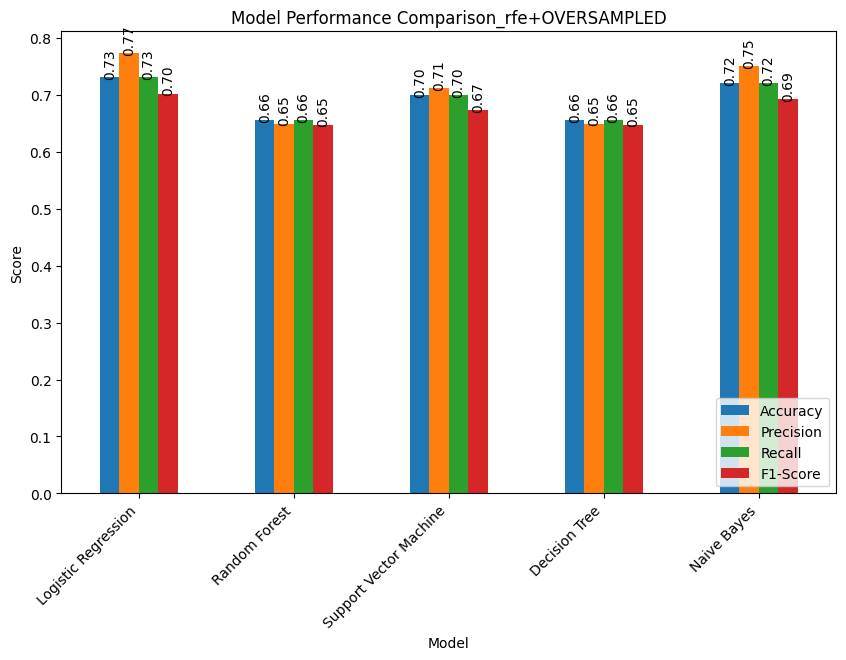

In [ ]:
# DataFrame for comparison with multiple metrics
comparison = pd.DataFrame({
    model_name: {
        "Accuracy": results["accuracy"],
        "Precision": results["classification_report"].loc["weighted avg", "precision"],
        "Recall": results["classification_report"].loc["weighted avg", "recall"],
        "F1-Score": results["classification_report"].loc["weighted avg", "f1-score"]
    }
    for model_name, results in results_dict_rfe_resampled.items()
}).transpose()

# Plotting multiple metrics
ax1 = comparison.plot(kind='bar', title="Model Performance Comparison_rfe+OVERSAMPLED", figsize=(10, 6))
plt.ylabel("Score")
plt.xlabel("Model")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.legend(loc='lower right')  # Adjust legend position if needed

# Add data labels (optional, similar to previous example)
for p in ax1.patches:
    ax1.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points', rotation=90)

plt.show()

**The Naive Bayes, and Logistic Regression turns out to be winning models**

### Case 2: Resampled Data and All variables

In [ ]:
results_dict_only_resampled = {}

train_and_evaluate_model(LogisticRegression(), "Logistic Regression", X_train, y_train, X_test, y_test, results_dict_only_resampled)
train_and_evaluate_model(RandomForestClassifier(), "Random Forest", X_train, y_train, X_test, y_test, results_dict_only_resampled)
train_and_evaluate_model(SVC(), "Support Vector Machine", X_train, y_train, X_test, y_test, results_dict_only_resampled)
train_and_evaluate_model(DecisionTreeClassifier(), "Decision Tree", X_train, y_train, X_test, y_test, results_dict_only_resampled)
train_and_evaluate_model(GaussianNB(), "Naive Bayes", X_train, y_train, X_test, y_test, results_dict_only_resampled)

### Performance Metrices of all the Models

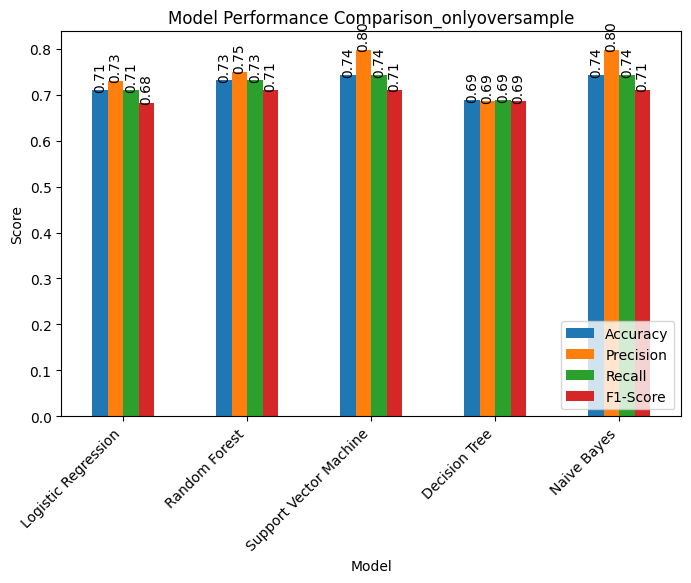

In [ ]:
# DataFrame for comparison with multiple metrics
comparison_only_resampled = pd.DataFrame({
    model_name: {
        "Accuracy": results["accuracy"],
        "Precision": results["classification_report"].loc["weighted avg", "precision"],
        "Recall": results["classification_report"].loc["weighted avg", "recall"],
        "F1-Score": results["classification_report"].loc["weighted avg", "f1-score"]
    }
    for model_name, results in results_dict_only_resampled.items()
}).transpose()

# Plotting multiple metrics
ax2 = comparison_only_resampled.plot(kind='bar', title="Model Performance Comparison_onlyoversample", figsize=(8, 5))
plt.ylabel("Score")
plt.xlabel("Model")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.legend(loc='lower right')  # Adjust legend position if needed

# Add data labels (optional, similar to previous example)
for p in ax2.patches:
    ax2.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points', rotation=90)

plt.show()



---



### Comparing the Performance Matrices for Both the Cases

In [ ]:
print("all features: \n",comparison_only_resampled.sort_values(by="Accuracy", ascending=False),"\n\nRFE features (9):\n" ,comparison.sort_values(by="Accuracy", ascending=False))

all features: 
                         Accuracy  Precision    Recall  F1-Score
Support Vector Machine  0.741935   0.797811  0.741935  0.710872
Naive Bayes             0.741935   0.797811  0.741935  0.710872
Random Forest           0.731183   0.749680  0.731183  0.710447
Logistic Regression     0.709677   0.730166  0.709677  0.682671
Decision Tree           0.688172   0.685089  0.688172  0.685904 

RFE features (9):
                         Accuracy  Precision    Recall  F1-Score
Logistic Regression     0.731183   0.772953  0.731183  0.701410
Naive Bayes             0.720430   0.750538  0.720430  0.692012
Support Vector Machine  0.698925   0.711519  0.698925  0.673376
Random Forest           0.655914   0.648814  0.655914  0.647338
Decision Tree           0.655914   0.648814  0.655914  0.647338


## Confusion Matrices

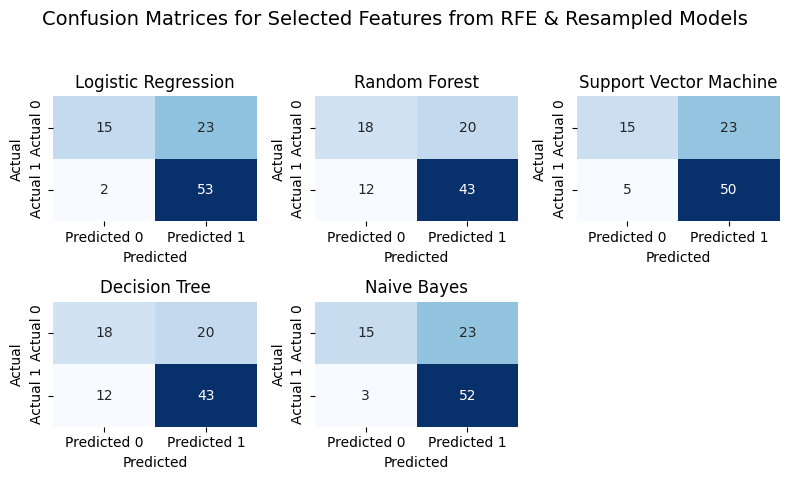

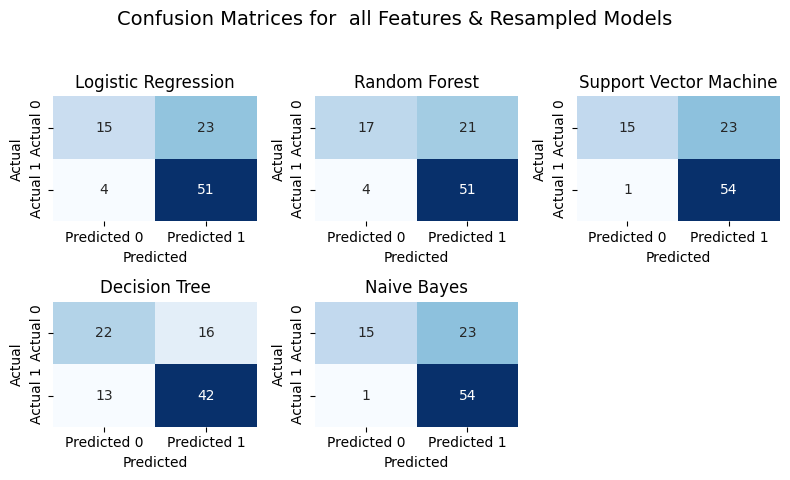

In [ ]:
# Function to plot confusion matrices
def plot_confusion_matrix(results_dict, title):
    plt.figure(figsize=(8, 5))
    for model_name, result in results_dict.items():
        matrix = result["confusion_matrix"]
        plt.subplot(2,3, list(results_dict.keys()).index(model_name) + 1)
        sns.heatmap(matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
        plt.title(f"{model_name}")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
    plt.suptitle(title, fontsize=14)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Plot confusion matrices for the RFE + resampled models
plot_confusion_matrix(results_dict_rfe_resampled, "Confusion Matrices for Selected Features from RFE & Resampled Models")

# Plot confusion matrices for the resampled models
plot_confusion_matrix(results_dict_only_resampled, "Confusion Matrices for  all Features & Resampled Models")

## ROC Curve

AUC values for RFE selected features and resampled models:
- Logistic Regression: 0.67
- Random Forest: 0.63
- Decision Tree: 0.62
- Naive Bayes: 0.65

AUC values for all features and resampled models:
- Logistic Regression: 0.68
- Random Forest: 0.71
- Decision Tree: 0.67
- Naive Bayes: 0.68


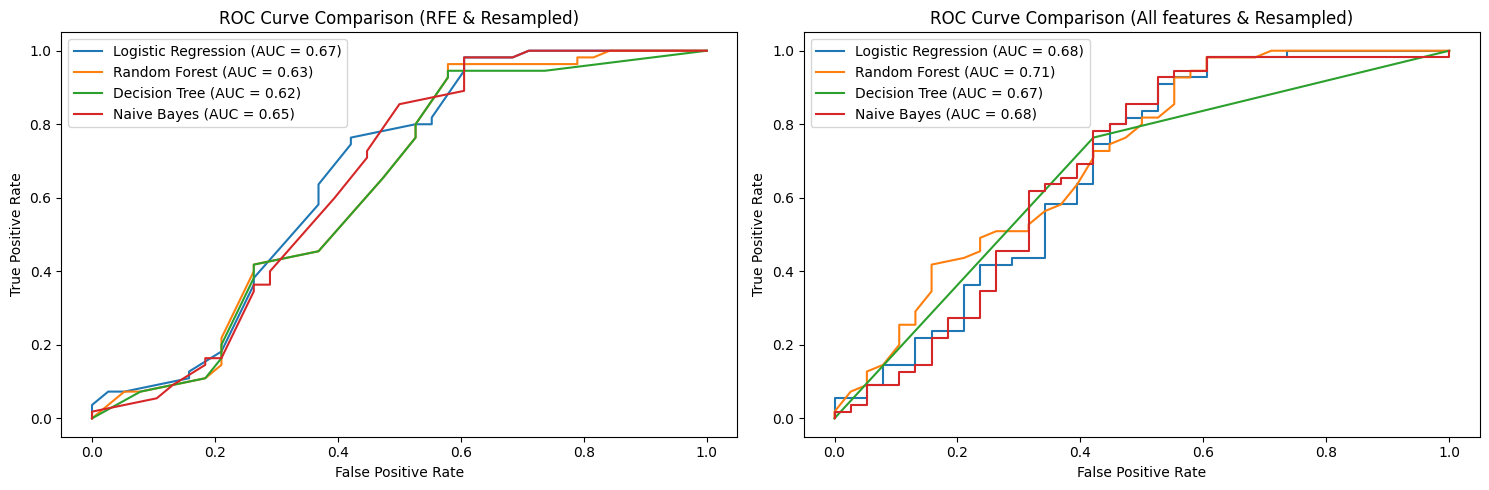

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot ROC curves for results_dict_rfe_resampled
print("AUC values for RFE selected features and resampled models:")
for model_name, result in results_dict_rfe_resampled.items():
    y_test_proba = result["y_pred_proba"]
    if y_test_proba is not None:
        auc_score = roc_auc_score(y_test, y_test_proba)
        print(f"- {model_name}: {auc_score:.2f}")  # Print AUC for this model
        fpr, tpr, _ = roc_curve(y_test, y_test_proba)
        axes[0].plot(fpr, tpr, label=f"{model_name} (AUC = {auc_score:.2f})")

axes[0].set_title("ROC Curve Comparison (RFE & Resampled)")
axes[0].set_xlabel("False Positive Rate")
axes[0].set_ylabel("True Positive Rate")
axes[0].legend()


# Plot ROC curves for results_dict_only_resampled
print("\nAUC values for all features and resampled models:")
for model_name, result in results_dict_only_resampled.items():
    y_test_proba = result["y_pred_proba"]
    if y_test_proba is not None:
        auc_score = roc_auc_score(y_test, y_test_proba)
        print(f"- {model_name}: {auc_score:.2f}")  # Print AUC for this model
        fpr, tpr, _ = roc_curve(y_test, y_test_proba)
        axes[1].plot(fpr, tpr, label=f"{model_name} (AUC = {auc_score:.2f})")

axes[1].set_title("ROC Curve Comparison (All features & Resampled)")
axes[1].set_xlabel("False Positive Rate")
axes[1].set_ylabel("True Positive Rate")
axes[1].legend()

plt.tight_layout()
plt.show()